Class-to-index mapping: {'B': 0, 'M': 1}
Using device: cuda


model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Epoch 1/20
Student Train - Loss: 0.2177, Accuracy: 0.8669
Student Val   - Loss: 0.2210, Accuracy: 0.7997
Epoch 2/20
Student Train - Loss: 0.1964, Accuracy: 0.9239
Student Val   - Loss: 0.1966, Accuracy: 0.9061
Epoch 3/20
Student Train - Loss: 0.1930, Accuracy: 0.9395
Student Val   - Loss: 0.2168, Accuracy: 0.7027
Epoch 4/20
Student Train - Loss: 0.1901, Accuracy: 0.9513
Student Val   - Loss: 0.1859, Accuracy: 0.9724
Epoch 5/20
Student Train - Loss: 0.1873, Accuracy: 0.9619
Student Val   - Loss: 0.1838, Accuracy: 0.9729
Epoch 6/20
Student Train - Loss: 0.1848, Accuracy: 0.9635
Student Val   - Loss: 0.1804, Accuracy: 0.9692
Epoch 7/20
Student Train - Loss: 0.1845, Accuracy: 0.9659
Student Val   - Loss: 0.1811, Accuracy: 0.9776
Epoch 8/20
Student Train - Loss: 0.1831, Accuracy: 0.9687
Student Val   - Loss: 0.1807, Accuracy: 0.9713
Epoch 9/20
Student Train - Loss: 0.1839, Accuracy: 0.9652
Student Val   - Loss: 0.1802, Accuracy: 0.9697
Epoch 10/20
Student Train - Loss: 0.1829, Accuracy: 0.9

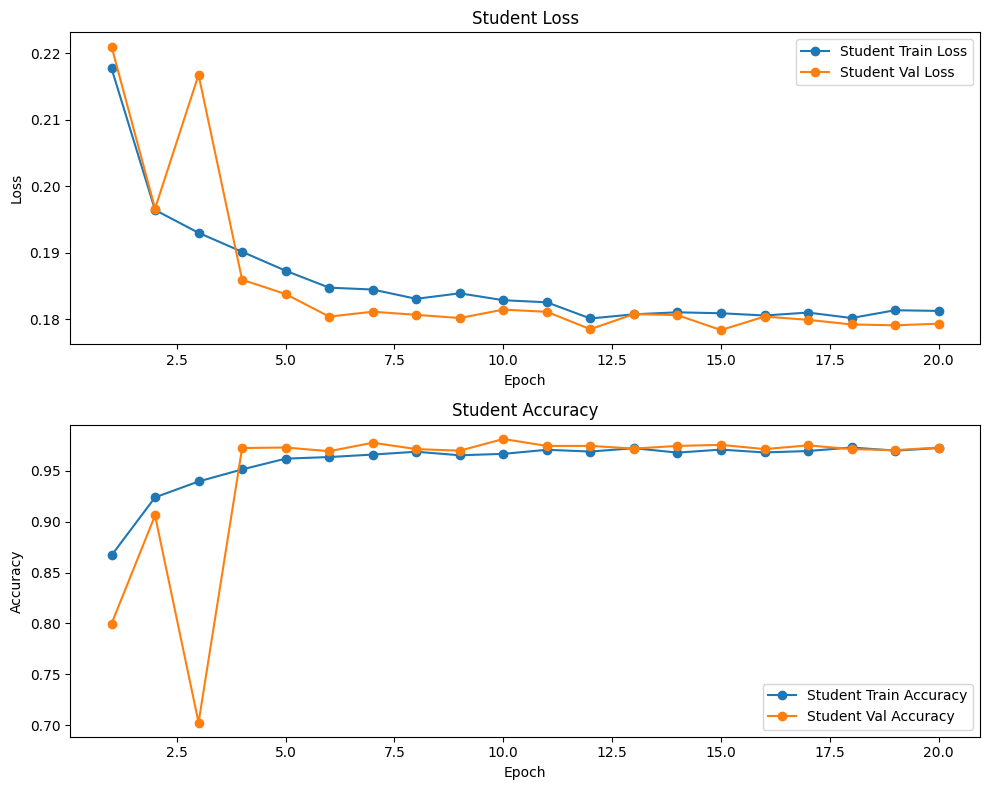

In [1]:
#Base paper Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from timm.models import create_model  # For ViT teacher model
from torchsummary import summary  # For model summaries
import matplotlib.pyplot as plt
import os
import types

# Paths
dataset_path = "/kaggle/input/enhanced-images/Attention_Dataset"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Test")

# Transformations for data preprocessing with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Label mapping
class_labels = {v: k for k, v in train_dataset.class_to_idx.items()}
print("Class-to-index mapping:", train_dataset.class_to_idx)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained ViT as the teacher model
teacher_model = create_model('deit_small_distilled_patch16_224', pretrained=True)
num_ftrs_teacher = teacher_model.head.in_features
teacher_model.head = nn.Linear(num_ftrs_teacher, 2)  # Change the output size to 2 classes
teacher_model.eval()
teacher_model = teacher_model.to(device)

# Fix the forward_head and forward_features for the teacher model to ensure correct output size
def forward_features(self, x):
    """
    Modified forward_features to properly process tokens.
    """
    x = self.patch_embed(x)  # Patch embedding
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # Add class token
    x = torch.cat((cls_token, x), dim=1)  # Combine class token and patches
    x = x + self.pos_embed[:, :x.size(1), :]  # Add positional embedding
    x = self.pos_drop(x)  # Apply dropout
    for block in self.blocks:  # Pass through transformer blocks
        x = block(x)
    x = self.norm(x)  # Normalize
    return x[:, 0]  # Return class token representation

def forward_head(self, x, pre_logits: bool = False):
    """
    Modified forward_head to ensure logits match the output size (2 classes).
    """
    if pre_logits:
        return x
    else:
        return self.head(x)  # Ensure output passes through the head layer

# Apply these methods to the teacher model
teacher_model.forward_features = types.MethodType(forward_features, teacher_model)
teacher_model.forward_head = types.MethodType(forward_head, teacher_model)

# Ensure the teacher model outputs logits of size (batch_size, 2)
def teacher_forward(self, x):
    """
    Complete forward pass for the teacher model.
    """
    x = self.forward_features(x)  # Extract features
    x = self.forward_head(x)  # Get final logits
    return x

# Replace the forward method in the teacher model
teacher_model.forward = types.MethodType(teacher_forward, teacher_model)

# Summary of the teacher model
#print("\nTeacher Model Summary:")
#summary(teacher_model, input_size=(3, 224, 224))

# Load pretrained ResNet50 as the student model
student_model = models.resnet50(pretrained=True)
num_ftrs = student_model.fc.in_features
student_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout for regularization
    nn.Linear(num_ftrs, 2)  # Output for 2 classes
)
student_model = student_model.to(device)

# Summary of the student model
#print("\nStudent Model Summary:")
#summary(student_model, input_size=(3, 224, 224))

# Knowledge Distillation Loss Function
def knowledge_distillation_loss(student_logits, teacher_logits, ground_truth, alpha, T):
    teacher_probs = F.softmax(teacher_logits / T, dim=1)
    student_probs = F.log_softmax(student_logits / T, dim=1)
    kd_loss = F.kl_div(student_probs, teacher_probs, reduction='batchmean') * (T ** 2)
    ce_loss = F.cross_entropy(student_logits, ground_truth)
    return alpha * kd_loss + (1 - alpha) * ce_loss

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)  # AdamW for better performance
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR after every 5 epochs

# Training and Validation Loops
num_epochs = 20  # Increased training time
alpha = 0.7
T = 5  # Higher temperature for better distillation
student_train_loss, student_val_loss = [], []
student_train_acc, student_val_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training Phase
    student_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            teacher_logits = teacher_model(inputs)
        student_logits = student_model(inputs)
        loss = knowledge_distillation_loss(student_logits, teacher_logits, labels, alpha, T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, student_predicted = torch.max(student_logits, 1)
        correct += (student_predicted == labels).sum().item()
        total += labels.size(0)

    student_train_loss.append(running_loss / len(train_loader))
    student_train_acc.append(correct / total)

    # Validation Phase
    student_model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            teacher_logits = teacher_model(inputs)
            student_logits = student_model(inputs)
            loss = knowledge_distillation_loss(student_logits, teacher_logits, labels, alpha, T)

            running_loss += loss.item()
            _, student_predicted = torch.max(student_logits, 1)
            correct += (student_predicted == labels).sum().item()
            total += labels.size(0)

    student_val_loss.append(running_loss / len(val_loader))
    student_val_acc.append(correct / total)

    scheduler.step()  # Update the learning rate

    print(f"Student Train - Loss: {student_train_loss[-1]:.4f}, Accuracy: {student_train_acc[-1]:.4f}")
    print(f"Student Val   - Loss: {student_val_loss[-1]:.4f}, Accuracy: {student_val_acc[-1]:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(10, 8))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), student_train_loss, label='Student Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), student_val_loss, label='Student Val Loss', marker='o')
plt.title("Student Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), student_train_acc, label='Student Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), student_val_acc, label='Student Val Accuracy', marker='o')
plt.title("Student Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Epoch 1: Train Acc=0.8763, Val Acc=0.8320
Epoch 2/20
Epoch 2: Train Acc=0.9211, Val Acc=0.8722
Epoch 3/20
Epoch 3: Train Acc=0.9416, Val Acc=0.9718
Epoch 4/20
Epoch 4: Train Acc=0.9546, Val Acc=0.9708
Epoch 5/20
Epoch 5: Train Acc=0.9616, Val Acc=0.9786
Epoch 6/20
Epoch 6: Train Acc=0.9713, Val Acc=0.9776
Epoch 7/20
Epoch 7: Train Acc=0.9706, Val Acc=0.9687
Epoch 8/20
Epoch 8: Train Acc=0.9750, Val Acc=0.9838
Epoch 9/20
Epoch 9: Train Acc=0.9703, Val Acc=0.9797
Epoch 10/20
Epoch 10: Train Acc=0.9708, Val Acc=0.9687
Epoch 11/20
Epoch 11: Train Acc=0.9805, Val Acc=0.9828
Epoch 12/20
Epoch 12: Train Acc=0.9821, Val Acc=0.9849
Epoch 13/20
Epoch 13: Train Acc=0.9795, Val Acc=0.9656
Epoch 14/20
Epoch 14: Train Acc=0.9811, Val Acc=0.9781
Epoch 15/20
Epoch 15: Train Acc=0.9821, Val Acc=0.9828
Epoch 16/20
Epoch 16: Train Acc=0.9866, Val Acc=0.9844
Epoch 17/20
Epoch 17: Train Acc=0.9871, Val Acc=0.9890
Epoch 18/20
Epoch 18: Train Acc=0.9887, Val Acc=0.9885
Epoch 19/20
Epoch 19: Train 

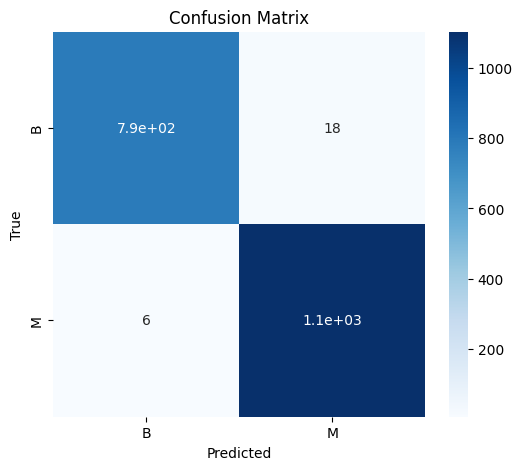

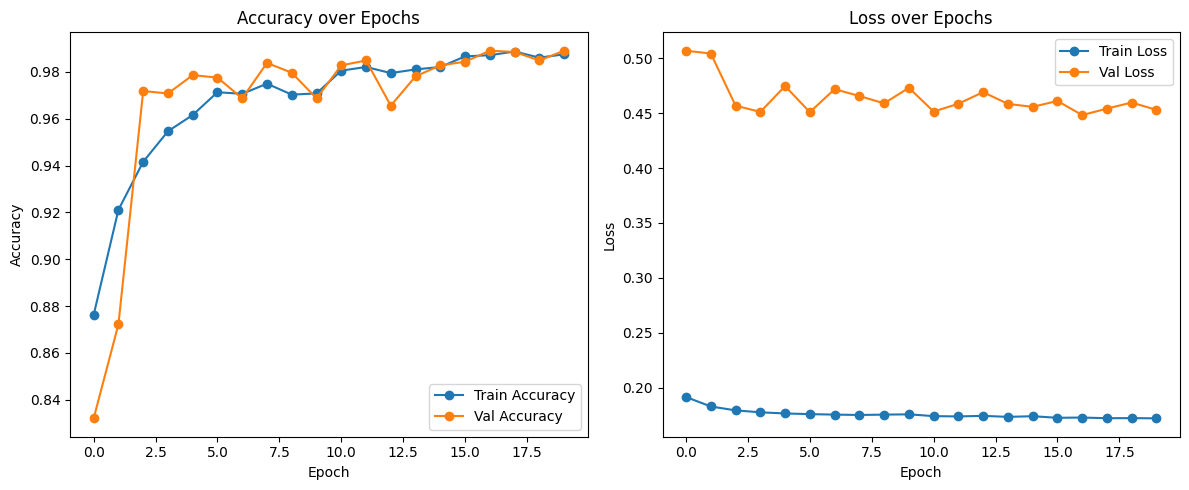

In [2]:
#Enhanced-ViT
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from timm.models import create_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

class HypergraphConv(nn.Module):
    def __init__(self, in_features, out_features, threshold=0.3, eps=1e-6):
        super(HypergraphConv, self).__init__()
        self.threshold = threshold
        self.eps = eps
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, X):
        B, P, D = X.shape
        X_norm = F.normalize(X, p=2, dim=2)
        S = torch.bmm(X_norm, X_norm.transpose(1, 2))
        H = (S > self.threshold).float()
        Dv = H.sum(dim=2) + self.eps
        Dv_inv_sqrt = Dv.pow(-0.5)
        De = H.sum(dim=1) + self.eps
        De_inv = De.pow(-1.0)
        X_normed = X * Dv_inv_sqrt.unsqueeze(-1)
        H_t_X = torch.bmm(H.transpose(1, 2), X_normed) * De_inv.unsqueeze(-1)
        aggregated = torch.bmm(H, H_t_X) * Dv_inv_sqrt.unsqueeze(-1)
        out = self.linear(aggregated)
        return F.relu(out)

class TModel(nn.Module):
    def __init__(self, base_teacher, hyper_in_dim, hyper_out_dim, num_classes):
        super(TModel, self).__init__()
        self.teacher = base_teacher
        for param in self.teacher.parameters():
            param.requires_grad = False
        self.hyper_conv = HypergraphConv(hyper_in_dim, hyper_out_dim)
        fusion_input_dim = self.teacher.num_features + hyper_out_dim
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, self.teacher.num_features),
            nn.LayerNorm(self.teacher.num_features),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Linear(self.teacher.num_features, num_classes)

    def forward(self, x):
        B = x.size(0)
        x_patches = self.teacher.patch_embed(x)
        cls_tokens = self.teacher.cls_token.expand(B, -1, -1)
        x_tokens = torch.cat((cls_tokens, x_patches), dim=1)
        x_tokens = x_tokens + self.teacher.pos_embed[:, :x_tokens.size(1), :]
        x_tokens = self.teacher.pos_drop(x_tokens)
        for block in self.teacher.blocks:
            x_tokens = block(x_tokens)
        x_tokens = self.teacher.norm(x_tokens)
        cls_token = x_tokens[:, 0]
        patch_tokens = x_tokens[:, 1:]
        hyper_features = self.hyper_conv(patch_tokens)
        hyper_features_avg = hyper_features.mean(dim=1)
        fusion_input = torch.cat((cls_token, hyper_features_avg), dim=1)
        fused_feature = self.fusion(fusion_input)
        logits = self.classifier(fused_feature)
        return logits

# Paths and Data
dataset_path = "/kaggle/input/enhanced-images/Attention_Dataset"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Test")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Teacher and Student
base_teacher = create_model('deit_small_distilled_patch16_224', pretrained=True)
TModel = TModel(base_teacher, base_teacher.num_features, 128, len(train_dataset.classes)).to(device)
TModel.eval()

SModel = models.resnet50(pretrained=True)
SModel.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(SModel.fc.in_features, len(train_dataset.classes))
)
SModel = SModel.to(device)

# KD Loss
def distillation_loss(student_logits, teacher_logits, labels, T=5, alpha=0.7):
    ce_loss = F.cross_entropy(student_logits, labels)
    soft_teacher = F.softmax(teacher_logits / T, dim=1)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    kd_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T ** 2)
    return alpha * kd_loss + (1 - alpha) * ce_loss

optimizer = torch.optim.AdamW(SModel.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training + Early Stopping
best_val_acc = 0
patience = 5
patience_counter = 0

train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(20):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    SModel.train()
    correct, total, epoch_loss = 0, 0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            teacher_logits = TModel(inputs)
        student_logits = SModel(inputs)
        loss = distillation_loss(student_logits, teacher_logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_acc.append(correct / total)
    train_loss.append(epoch_loss / len(train_loader))

    SModel.eval()
    correct, total, epoch_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = SModel(inputs)
            loss = F.cross_entropy(outputs, labels)
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    current_val_acc = correct / total
    val_acc.append(current_val_acc)
    val_loss.append(epoch_loss / len(val_loader))
    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluation
SModel.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = SModel(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Val Accuracy', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# Save the entire model (not just state_dict)
model_save_path = "/kaggle/working/full_student_model.pth"
torch.save(SModel, model_save_path)
print(f"Entire model saved to {model_save_path}")

Entire model saved to /kaggle/working/full_student_model.pth


In [5]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full model
model_load_path = "/kaggle/working/full_student_model.pth"
SModel = torch.load(model_load_path, map_location=device)
SModel.eval().to(device)

/tmp/ipykernel_31/2467631653.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  SModel = torch.load(model_load_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
from torchvision import transforms
from PIL import Image

# Prediction function
def predict_image(image_path, class_names):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = SModel(input_tensor)
        predicted = torch.argmax(output, dim=1).item()

    print(f"Predicted Class: {class_names[predicted]}")
    return class_names[predicted]

# Example usage:
image_path = "/kaggle/input/enhanced-images/Attention_Dataset/Test/B/00216736d5b7a5f18e87769195d69e95da8da267f06114755df2dcce9ed03981_attention.png"
predict_image(image_path, train_dataset.classes)

Predicted Class: B


'B'

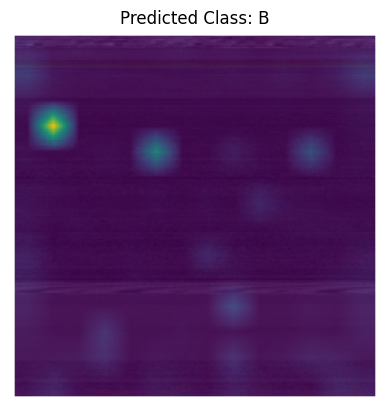

Predicted Class: B


In [7]:
# Function to make predictions with the student model
def predict_image(image_path, model, class_labels, device):
    """
    Predict the class of an image using the trained student model.

    Args:
        image_path (str): Path to the image file.
        model (nn.Module): Trained student model.
        class_labels (dict): Mapping of class indices to labels.
        device (torch.device): Device to run the prediction on.

    Returns:
        str: Predicted class label for the image.
    """
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform the prediction
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_class = torch.max(output, 1)
            predicted_label = class_labels[predicted_class.item()]

        # Display the image with the predicted class
        plt.imshow(image)
        plt.title(f"Predicted Class: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Example Usage
image_path = "/kaggle/input/enhanced-images/Attention_Dataset/Test/B/00216736d5b7a5f18e87769195d69e95da8da267f06114755df2dcce9ed03981_attention.png"  # Replace with your image path
predicted_label = predict_image(image_path, SModel,train_dataset.classes, device)
print(f"Predicted Class: {predicted_label}")